# Predict Nighttime Light Intensities from Daytime Light 

First pass.  
Current Goal: Use CNN to extract features from daytime lights (Landsat) data and predict levels of nighhtime light intensities (VIIRS).
***
General Steps:
1. Import the data
2. Feature creation
3. Build the Neural Net
4. Evaluate the Neural Net

In [1]:
import os
import pandas as pd
import geopandas as gpd
import rasterio

import getpass

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten

In [4]:
# Rob's code
if getpass.getuser() == 'robmarty':
    project_file_path = '/Users/robmarty/Dropbox/World Bank/IEs/Pakistan Poverty Estimation from Satellites'
    
filepath_night = project_file_path + "/Data/VIIRS/RawData/VIIRS Annual/pak_viirs_median_2012.tif"
data_night = rasterio.open(filepath_night)
array_night = data_night.read()
np.nanmean(array_night)

array_night_flat = array_night.flatten()
array_night_flat_nona = array_night_flat[ ~np.isnan(array_night_flat) ]
plt.hist(array_night_flat_nona)

# 1. Import and Prep Data

## 1a. Setup, Load, and Prep Daytime Lights Data

In [2]:
# Set directory
os.chdir("/Users/nguyenluong/wb_internship/Data/satellite_raw")

def read_geotiff(filepath):
    data = rasterio.open(filepath)
    return data.read()

def get_daytime_data(geotiff_source, year, stacked_status):
    all_data = []
    directory = os.path.join(geotiff_source, year, stacked_status)
    for filename in os.listdir(directory):
        if filename.endswith(".tif"):
            filepath = os.path.join(directory, filename)
            geotiff_array = read_geotiff(filepath)
            all_data.append(geotiff_array)
    return all_data

In [ ]:
# Define years for daytime data
Landsat_years = ['2013']

# Load in all daytime data
all_daytime_data = []
for year in Landsat_years:
    all_daytime_data.append((year, get_daytime_data('Landsat', year, 'stacked')))

## 1b. Load and Prep Nighttime Lights Data 

In [3]:
# Load nighttime VIIRS data (geojson)
viirs_poly_gdf = gpd.read_file('VIIRS/VIIRS Annual/viirs_annual_polygon.geojson')

Transform nighttime lights to lessen heavily skewed distribution. For now, **limit to only 2013 data**.   
***
Options tried here:
- natural log
- square root
- box-cox
- yeo-johnson

doc: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.power_transform.html#r742a88cfa144-1

In [4]:
from sklearn.preprocessing import power_transform

# Do log(x + 1) to have fully defined domain since data has x = 0
log_rad = np.log(viirs_poly_gdf['median_rad_2013'] + 1).to_numpy()

sqrt_rad = np.sqrt(viirs_poly_gdf['median_rad_2013']).to_numpy()

# do box-cox with (x + 1) because needs strictly positive values 
bc_rad = power_transform((viirs_poly_gdf['median_rad_2013'] + 1)\
                             .to_numpy().reshape(-1, 1), method='box-cox')

yj_rad = power_transform((viirs_poly_gdf['median_rad_2013'])\
                             .to_numpy().reshape(-1, 1), method='yeo-johnson')

Explore the distributions of variable transformations to decide which to go forward with.

Summary of log
DescribeResult(nobs=1814237, minmax=(0.0, 7.483210362133503), mean=0.21201183626794542, variance=0.0631144546408545, skewness=6.5342432701103235, kurtosis=63.18404380925924)

Summary of square-root
DescribeResult(nobs=1814237, minmax=(0.0, 42.15375965587174), mean=0.4690969454140062, variance=0.10915777482006311, skewness=13.786617024046127, kurtosis=719.8342478686386)

Summary of box-cox
DescribeResult(nobs=1814237, minmax=(-3.486867345101547, 2.2625341729099766), mean=-2.325074632929899e-15, variance=1.0000005511962058, skewness=0.6840783490207888, kurtosis=-0.4117379445822089)

Summary of yeo-johnson
DescribeResult(nobs=1814237, minmax=(-3.486867345101547, 2.2625341729099766), mean=-2.325074632929899e-15, variance=1.0000005511962058, skewness=0.6840783490207888, kurtosis=-0.4117379445822089)



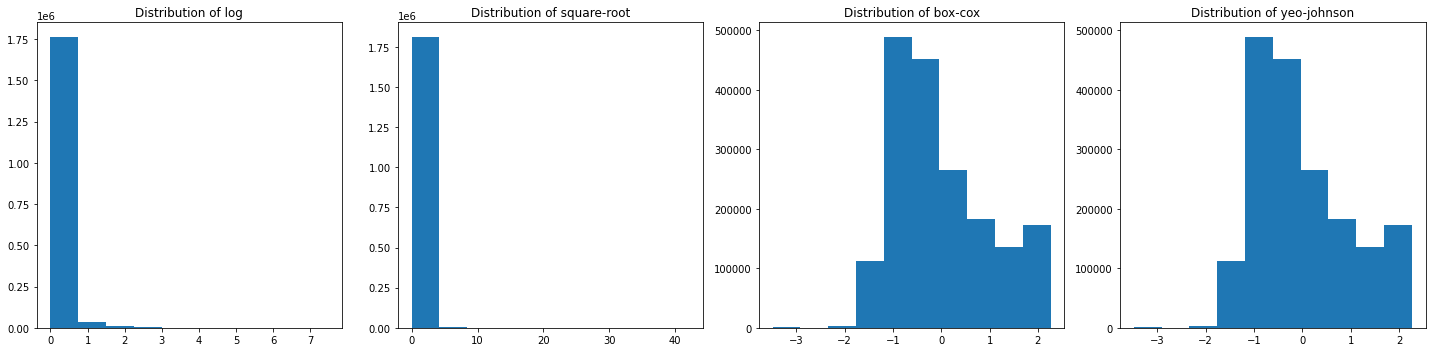

In [6]:
from scipy import stats

def explore_distrib(vars_dict):
    fig, ax = plt.subplots(figsize=(20,5), ncols=len(vars_dict.values()))
    i = 0
    for var_name, array in vars_dict.items():
        if len(array.shape) > 1:
            array = array.flatten()
        print('Summary of ' + var_name)
        print(stats.describe(array))
        print()
        ax[i].hist(array);
        ax[i].set_title('Distribution of ' + var_name);
        i += 1
    plt.tight_layout()
    plt.show()

vars_dict = {'log': log_rad, 'square-root': sqrt_rad, 
             'box-cox': bc_rad, 'yeo-johnson': yj_rad}
explore_distrib(vars_dict)

I feel like it makes sense to feel values positive for interpretation of radiance. Log has lowered skewness and smaller range of values. So, I will discretize log median radiance for 2013 with k-means clustering.

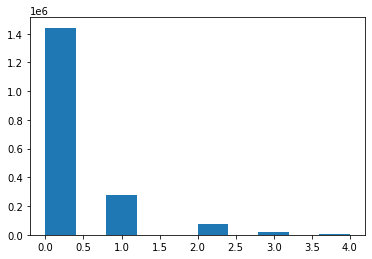

In [7]:
from sklearn.preprocessing import KBinsDiscretizer
# Reshape array to be a column rather than a row
log_rad = log_rad.reshape(-1,1)
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
log_binned = discretizer.fit_transform(log_rad)
plt.hist(log_binned);

In [22]:
# Now nighttime lights is bucketed into 5 categories
print('Bin: {}'.format(np.unique(log_binned)))
print('Bin edges: {}'.format(discretizer.bin_edges_[0]))

Bin: [0. 1. 2. 3. 4.]
Bin edges: [0.         0.23858741 0.53132507 1.10071912 2.15036929 7.48321036]


# Feature Creation
Reshape the data into an array of 3D tensors and normalize each element.
***  
*What satellite data ultimately needs to look like*
- data_train, data_test: (np.array) array containing 3D arrays each representing one Landsat image
- target_train, target_test: (np.array with elements in range(0,5)) 1D array of nighttime light intensities split into 5 buckets

In [6]:
#Sample data
from keras.datasets import mnist
(trainX, trainY), (testX, testY) = mnist.load_data()

In [7]:
#Look at array shapes
print('training data shape: {}'.format(trainX.shape))
print('training target shape: {}'.format(trainY.shape))
print('testing data shape: {}'.format(testX.shape))
print('testing target shape: {}'.format(testY.shape))

training data shape: (60000, 28, 28)
training target shape: (60000,)
testing data shape: (10000, 28, 28)
testing target shape: (10000,)


target value: 5


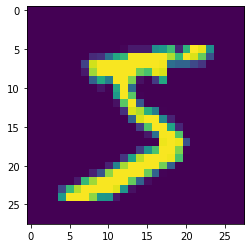

In [8]:
#Sample image and target
plt.imshow(trainX[0], origin='upper', interpolation='nearest');
print('target value: {}'.format(trainY[0]))

In [9]:
def prep_dataset(X, Y, height, width, channels):
    # Reshape dataset to have include a single channel
    X = X.reshape((X.shape[0], height, width, channels))
    # One-hot encode targets
    Y = to_categorical(Y)
    return X, Y

def normalize(X):
    # Convert from ints to floats and normalize to 0-1
    return X.astype('float32') / 255.0

# Build the CNN

In [10]:
def define_model(height, width, channels, num_classes):
    # Define layers
    model = Sequential()
    model.add(Conv2D(filters=64, 
                     kernel_size=(5, 5), 
                     activation='relu', 
                     input_shape=(height, width, channels)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    print('Model has been defined. Model summary below.')
    model.summary()
    
    return model

# Evaluate the CNN

In [11]:
def evaluate_model(model, trainX, trainY, testX, testY):
    # Fit model
    history = model.fit(trainX, trainY, 
                        epochs=2, batch_size=1000, 
                        validation_data=(testX, testY), verbose=0)
    print('Model has been fit.')
    
    # Evaluate model
    loss, accuracy = model.evaluate(testX, testY, verbose=0)
    print('Model has been evaluted.')
    print('Accuracy: {:.4f}'.format(accuracy))


def evaluate_with_crossval(model, dataX, dataY, k=2):
    # Define k-fold cross-val
    kfold = KFold(k, shuffle=True, random_state=1)
    print('Entering cross validation.')
    
    # Loop through folds
    for train_idx, test_idx in kfold.split(dataX):
        # Select subsets for training and testing
        trainX, trainY, testX, testY = dataX[train_idx], dataY[train_idx], dataX[test_idx], dataY[test_idx]
        print('Subsets have been selected.')
        # Pass to evaluate_model
        evaluate_model(model, trainX, trainY, testX, testY)

In [12]:
def go():
    # Load dataset
    (raw_trainX, raw_trainY), (raw_testX, raw_testY) = mnist.load_data()
    
    # Define image characteristics
    height = raw_trainX[0].shape[0]
    width = raw_trainX[0].shape[1]
    channels = 1
    num_classes = 10 #digits 0-9
    
    # Prep both training and testing data
    trainX, trainY = prep_dataset(raw_trainX, raw_trainY, height, width, channels)
    testX, testY = prep_dataset(raw_testX, raw_testY, height, width, channels)
    
    # Prep pixel data
    trainX, testX = normalize(trainX), normalize(testX)

    # Define and evaluate model
    model = define_model(height, width, channels, num_classes)
    evaluate_model(model, trainX, trainY, testX, testY)
    #evaluate_with_crossval(model, trainX, trainY)

In [13]:
go()

Model has been defined. Model summary below.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               921700    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 924,374
Trainable params: 924,374
Non-trainable params: 0
_________________________________________________________________
Model has been fit.
Model has been evaluted.
Accuracy: 0.9714
